Project 1

Using CIFAR-10 dataset

Using Tensorflow

Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50
from tensorflow.keras import datasets, layers, models, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Preprocessing

170498071/170498071 [==============================] - 13s 0us/step


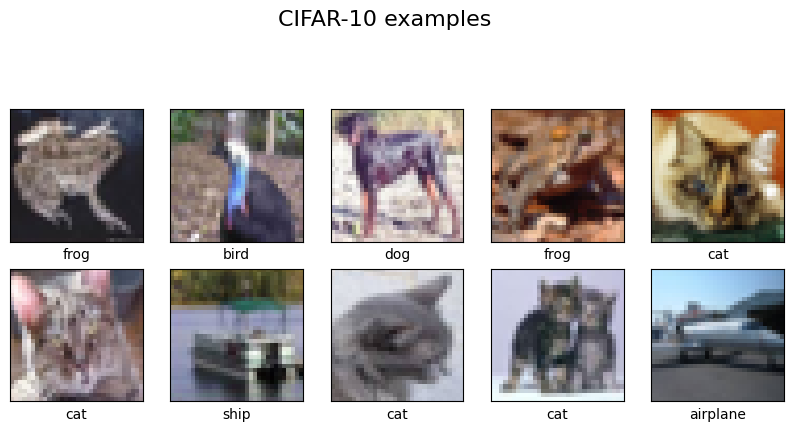

In [2]:
# Load data
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Split training data into train an validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Define list with class names
class_names = [
  'airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'
]

# Normalization
train_images = train_images / 255.0
test_images = test_images / 255.0
val_images = val_images / 255.0

# Augmentation
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    zoom_range = 0.2,
    fill_mode = 'nearest'
)
datagen.fit(train_images)

# Visualization
plt.figure(figsize=(10,10))
plt.suptitle(f"CIFAR-10 examples", fontsize=16)
for i in range(10):
  plt.subplot(5,5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i][0]])
plt.show()



Model Architecture

In [3]:
# Define early stopping function
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Define lerning rate scheduler function
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

def create_cnn_layers(input_tensor):
    """
    Creates the convolutional layers for a CNN model.

    Args:
        input_tensor (Tensor): Input tensor to the CNN layers.

    Returns:
        Tensor: Output tensor after applying the convolutional, batch normalization,
                max pooling, flatten, dense, and dropout layers.

    This function builds a series of convolutional, batch normalization, and max pooling layers to extract features
    from the input tensor.
    """
    # First Convolutional layer with 32 filters to receive the input and capture low-level features like edges, textures, etc.
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # Second  Convolutional layer with 64 filters to capture, builds upon the features detected by first layer, complex features.
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # Third  Convolutional layer with 128 filters to capture, builds upon the features detected by second layer, more complex features.
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # Fourth  Convolutional layer with 128 filters to capture, builds upon the features detected by third layer, more complex features.
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    # Flatten layer to convert 3D output to 1D feature vector.
    x = layers.Flatten()(x)
    # Dense layer with 128 units and ReLU activation.
    x = layers.Dense(128, activation='relu')(x)
    # Dropout layer with 0.5 dropout rate for regularization.
    x = layers.Dropout(0.5)(x)
    # Final Dense layer with 10 units (classes) and softmax activation for classification.
    output_tensor = layers.Dense(10, activation='softmax')(x)
    return output_tensor

def create_cnn_model():
    """
    Creates and returns a compiled CNN model for CIFAR-10 classification.

    This function defines the input shape for the model, constructs the convolutional layers by
    calling the create_cnn_layers function, and then creates the Model object.

    Returns:
        model (Model): A compiled Keras Model object.
    """
    input_tensor = layers.Input(shape=(32, 32, 3))
    output_tensor = create_cnn_layers(input_tensor)
    model = models.Model(inputs=input_tensor, outputs=output_tensor)
    return model

model_cn = create_cnn_model()

model_cn.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 64)        256   

Model Training

In [4]:
# Compile the model
model_cn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_cn.fit(
    datagen.flow(train_images, to_categorical(train_labels), batch_size=32),
    epochs = 100,
    validation_data=(val_images, to_categorical(val_labels)),
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
1250/1250 [==============================] - 168s 132ms/step - loss: 1.9589 - accuracy: 0.2769 - val_loss: 2.5359 - val_accuracy: 0.2899 - lr: 0.0010
Epoch 2/100
1250/1250 [==============================] - 159s 127ms/step - loss: 1.7194 - accuracy: 0.3675 - val_loss: 1.6686 - val_accuracy: 0.4430 - lr: 0.0010
Epoch 3/100
1250/1250 [==============================] - 161s 129ms/step - loss: 1.5751 - accuracy: 0.4293 - val_loss: 1.4712 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 4/100
1250/1250 [==============================] - 158s 127ms/step - loss: 1.4754 - accuracy: 0.4756 - val_loss: 1.1462 - val_accuracy: 0.5908 - lr: 0.0010
Epoch 5/100
1250/1250 [==============================] - 160s 128ms/step - loss: 1.3977 - accuracy: 0.5076 - val_loss: 1.3731 - val_accuracy: 0.5283 - lr: 0.0010
Epoch 6/100
1250/1250 [==============================] - 163s 130ms/step - loss: 1.3315 - accuracy: 0.5335 - val_loss: 1.1510 - val_accuracy: 0.5992 - lr: 0.0010
Epoch 7/100
1250/1250 [=====

Model Evaluate

313/313 - 1s - loss: 0.5892 - accuracy: 0.8055 - 734ms/epoch - 2ms/step
Test accuracy: 0.81
313/313 [==============================] - 1s 2ms/step
Accuracy: 0.81
Precision: 0.81
Recall: 0.81
F1-score: 0.80
Classification Report:
               precision    recall  f1-score   support

    airplane       0.83      0.85      0.84      1000
  automobile       0.85      0.94      0.89      1000
        bird       0.82      0.66      0.74      1000
         cat       0.72      0.62      0.67      1000
        deer       0.85      0.72      0.78      1000
         dog       0.80      0.71      0.75      1000
        frog       0.70      0.93      0.79      1000
       horse       0.81      0.88      0.84      1000
        ship       0.92      0.87      0.90      1000
       truck       0.80      0.88      0.84      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.80     10000



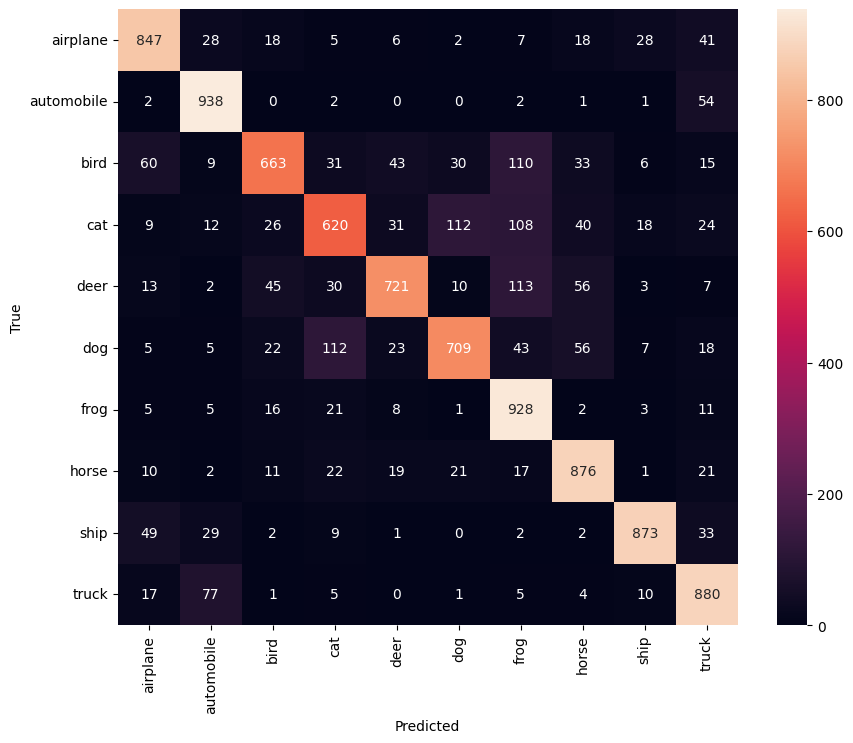

In [5]:
# Evaluate the model
test_loss, test_acc = model_cn.evaluate(test_images, to_categorical(test_labels), verbose=2)
print(f'Test accuracy: {test_acc:.2f}')

# Predictions
test_predictions = model_cn.predict(test_images)
test_predictions = test_predictions.argmax(axis=1)
test_labels = test_labels.flatten()

# Metrics
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average='macro')
recall = recall_score(test_labels, test_predictions, average='macro')
f1 = f1_score(test_labels, test_predictions, average='macro')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Classification Report
report = classification_report(test_labels, test_predictions, target_names=class_names)
print('Classification Report:\n', report)

# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Transfer Learning

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/20
1250/1250 [==============================] - 26s 20ms/step - loss: 1.8049 - accuracy: 0.3572 - val_loss: 1.4513 - val_accuracy: 0.4871 - lr: 0.0010
Epoch 2/20
1250/1250 [==============================] - 24s 19ms/step - loss: 1.6437 - accuracy: 0.4200 - val_loss: 1.3985 - val_accuracy: 0.4995 - lr: 0.0010
Epoch 3/20
1250/1250 [==============================] - 24s 19ms/step - loss: 1.6074 - accuracy: 0.4326 - val_loss: 1.3468 - val_accuracy: 0.5241 - lr: 0.0010
Epoch 4/20
1250/1250 [==============================] - 24s 19ms/step - loss: 1.5746 - accuracy: 0.4426 - val_loss: 1.3567 - val_accuracy: 0.5213 - lr: 0.0010
Epoch 5/20
1250/1250 [==============================] - 24s 19ms/step - loss: 1.5627 - accuracy: 0.4493 - val_loss: 1.3241 - val_accuracy: 0.5328 - lr: 0.0010
Epoch 6/20
1250/1250 [==============================] - 24s 19ms/step - loss: 1.5527 - accuracy: 0.4521 - val_loss: 1.3140 - val_accuracy: 0

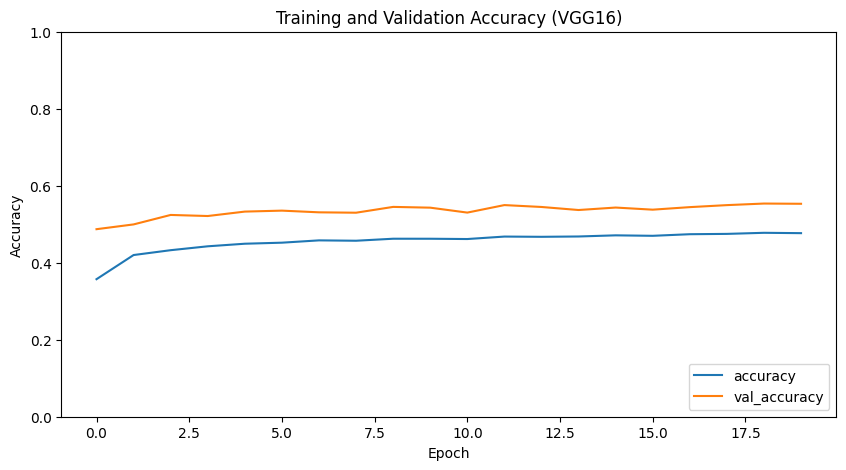

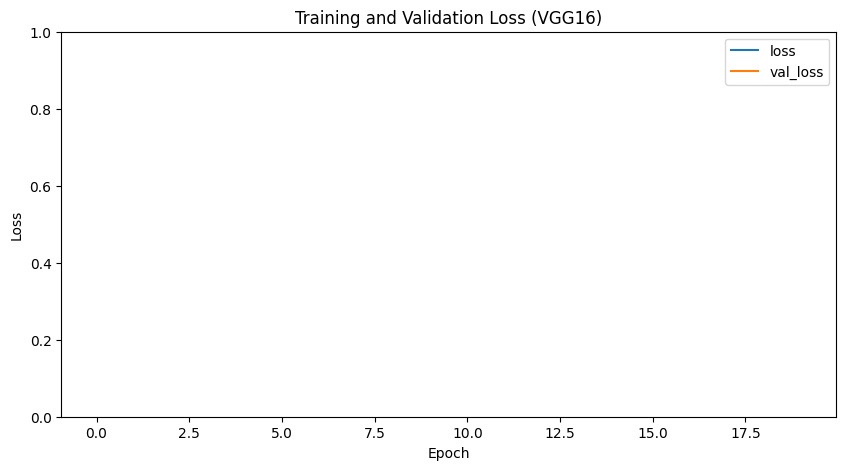

Epoch 1/20
1250/1250 [==============================] - 73s 54ms/step - loss: 1.7348 - accuracy: 0.3837 - val_loss: 1.3405 - val_accuracy: 0.5366 - lr: 0.0010
Epoch 2/20
1250/1250 [==============================] - 65s 52ms/step - loss: 1.5586 - accuracy: 0.4487 - val_loss: 1.2882 - val_accuracy: 0.5483 - lr: 0.0010
Epoch 3/20
1250/1250 [==============================] - 66s 53ms/step - loss: 1.5171 - accuracy: 0.4672 - val_loss: 1.2610 - val_accuracy: 0.5595 - lr: 0.0010
Epoch 4/20
1250/1250 [==============================] - 65s 52ms/step - loss: 1.4937 - accuracy: 0.4710 - val_loss: 1.2438 - val_accuracy: 0.5651 - lr: 0.0010
Epoch 5/20
1250/1250 [==============================] - 65s 52ms/step - loss: 1.4902 - accuracy: 0.4746 - val_loss: 1.2521 - val_accuracy: 0.5709 - lr: 0.0010
Epoch 6/20
1250/1250 [==============================] - 65s 52ms/step - loss: 1.4629 - accuracy: 0.4830 - val_loss: 1.2434 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 7/20
1250/1250 [========================

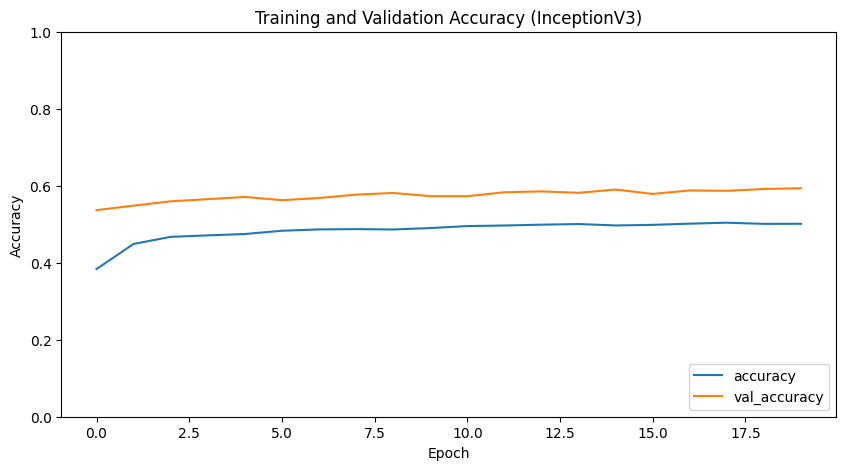

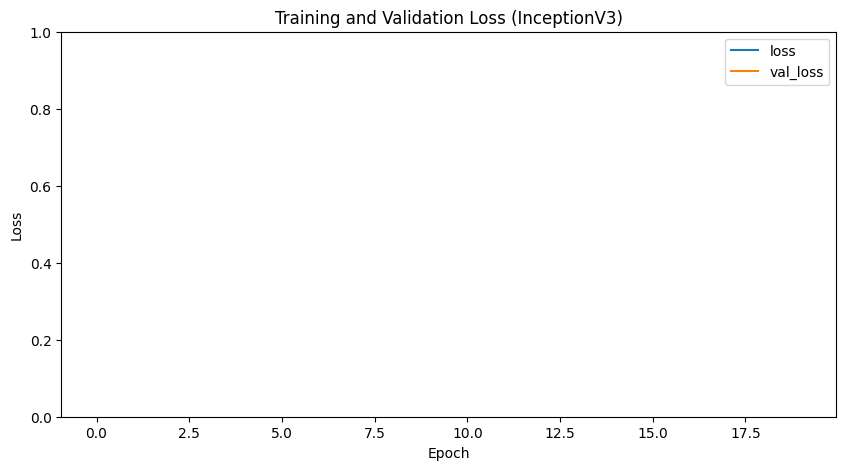

Epoch 1/20
1250/1250 [==============================] - 31s 22ms/step - loss: 2.3111 - accuracy: 0.0988 - val_loss: 2.3027 - val_accuracy: 0.0973 - lr: 0.0010
Epoch 2/20
1250/1250 [==============================] - 26s 21ms/step - loss: 2.3028 - accuracy: 0.0999 - val_loss: 2.3030 - val_accuracy: 0.0934 - lr: 0.0010
Epoch 3/20
1250/1250 [==============================] - 26s 21ms/step - loss: 2.3028 - accuracy: 0.0993 - val_loss: 2.3030 - val_accuracy: 0.0933 - lr: 0.0010
Epoch 4/20
1250/1250 [==============================] - 26s 21ms/step - loss: 2.3028 - accuracy: 0.1011 - val_loss: 2.3030 - val_accuracy: 0.0972 - lr: 0.0010
Epoch 5/20
1250/1250 [==============================] - 26s 20ms/step - loss: 2.3028 - accuracy: 0.0987 - val_loss: 2.3028 - val_accuracy: 0.0933 - lr: 0.0010
Epoch 6/20
1248/1250 [============================>.] - ETA: 0s - loss: 2.3028 - accuracy: 0.0981
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 [====================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

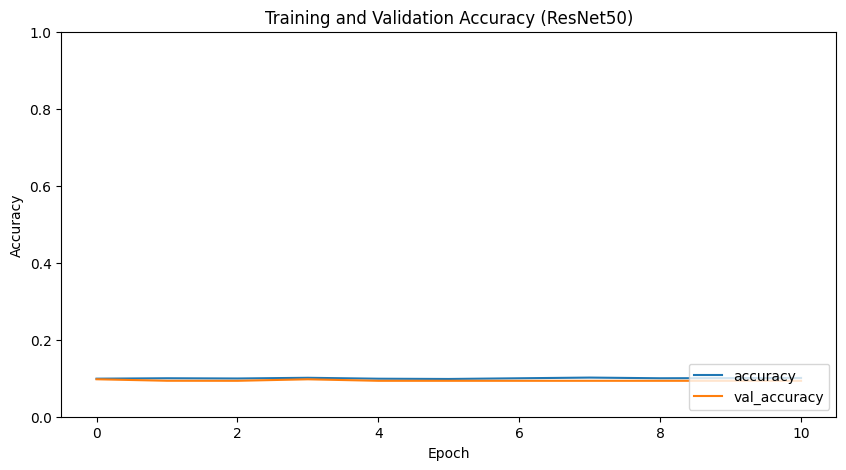

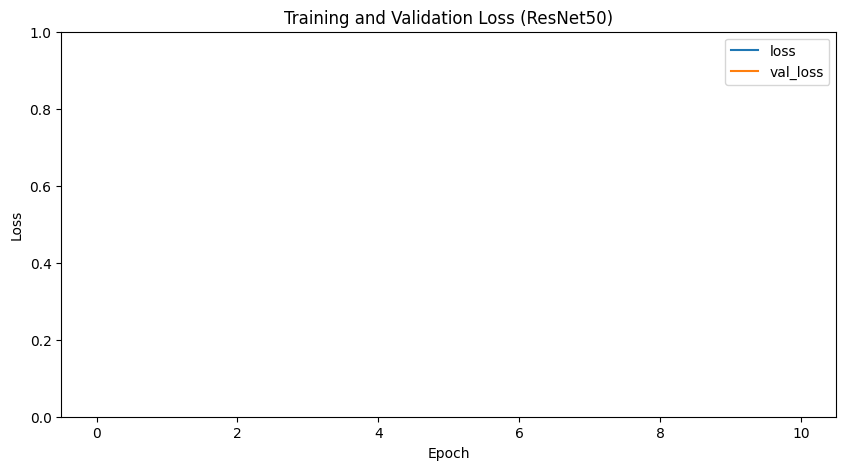

In [ ]:
# To fair compare models will use same conditions

def create_model(base_model):
    """
    Creates a model by adding custom top layers to a base pre-trained model.

    Args:
        base_model (tf.keras.Model): The base pre-trained model (e.g., VGG16, InceptionV3, ResNet50).

    Returns:
        tf.keras.Model: The combined model with the base model and custom top layers.

    This function freezes the layers of the base model to prevent them from being trained further.
    """

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(10, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model



def compile_and_train(model, model_name):
    """
    Compiles and trains the given model, and evaluates its performance.

    Args:
        model (tf.keras.Model): The model to be trained and evaluated.
        model_name (str): The name of the model (used for display purposes).

    This function compiles the model with the Adam optimizer and categorical crossentropy loss.
    It adjusts the image sizes for InceptionV3 as it requires larger input dimensions.
    The model is trained using data augmentation, and the training history is recorded.
    Finally, the model's performance is evaluated on the test set, and metrics such as accuracy,
    precision, recall, and F1-score are printed.
    """

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Adjust image sizes for InceptionV3
    if model_name == "InceptionV3":
        _train_images = tf.image.resize(train_images, (75, 75))
        _val_images = tf.image.resize(val_images, (75, 75))
        _test_images = tf.image.resize(test_images, (75, 75))
    else:
        _train_images = train_images
        _val_images = val_images
        _test_images = test_images

    # Train the model
    history = model.fit(
        datagen.flow(_train_images, to_categorical(train_labels), batch_size=32),
        epochs=20,
        validation_data=(_val_images, to_categorical(val_labels)),
        callbacks=[early_stopping, lr_scheduler]
    )

    # Evaluate the model
    test_predictions = model.predict(_test_images).argmax(axis=1)
    test_labels_flat = test_labels.flatten()

    accuracy = accuracy_score(test_labels_flat, test_predictions)
    print(f'{model_name} Model Accuracy: {accuracy:.2f}')

    precision = precision_score(test_labels_flat, test_predictions, average=None)
    recall = recall_score(test_labels_flat, test_predictions, average=None)
    f1 = f1_score(test_labels_flat, test_predictions, average=None)

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1}')

    report = classification_report(test_labels_flat, test_predictions, target_names=class_names)
    print(f'Classification Report for {model_name}:\n', report)

# Inputs tensor
input_tensor = layers.Input(shape=(32, 32, 3))
input_tensor_inception = layers.Input(shape=(75, 75, 3))

# VGG16 model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
vgg16_model = create_model(vgg16_base)

# InceptionV3 model
inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor_inception)
inception_model = create_model(inception_base)

# ResNet50 model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
resnet_model = create_model(resnet_base)

# Train and evaluate each model
compile_and_train(vgg16_model, "VGG16")
compile_and_train(inception_model, "InceptionV3")
compile_and_train(resnet_model, "ResNet50")

**Results**:

VGG16 Model Accuracy: 0.55

InceptionV3 Model Accuracy: 0.60 (Star)

ResNet50 Model Accuracy: 0.10

Combine VGG16 with CNN model

In [ ]:
# When I was using MaxPoolin2D layers, the features maps were very small and I was getting error
def create_cnn_layers_without_maxpooling2D(input_tensor):
  """
  Creates CNN layers without MaxPooling2D to prevent feature maps from becoming too small.

  Args:
      input_tensor (Tensor): Input tensor to the CNN layers.

  Returns:
      Tensor: Output tensor after applying convolutional, batch normalization, flatten, dense, and dropout layers.

  This function builds a series of convolutional and batch normalization layers to extract features
  from the input tensor without using MaxPooling2D layers.
  """
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  output_tensor = layers.Dense(10, activation='softmax')(x)
  return output_tensor


# Load VGG16 model without the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
# Freeze the layers of the base model to prevent them from being trained
for layer in vgg16_base.layers:
    layer.trainable = False
# Create custom layers
vgg16_output = vgg16_base.output
cnn_output = create_cnn_layers_without_maxpooling2D(vgg16_output)
# Create the combined model
combined_model = models.Model(inputs=vgg16_base.input, outputs=cnn_output)
combined_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

Epoch 1/100
1250/1250 [==============================] - 630s 500ms/step - loss: 1.6718 - accuracy: 0.4162 - val_loss: 1.4989 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 2/100
1250/1250 [==============================] - 579s 463ms/step - loss: 1.6202 - accuracy: 0.4384 - val_loss: 1.4054 - val_accuracy: 0.4976 - lr: 0.0010
Epoch 3/100
1250/1250 [==============================] - 617s 494ms/step - loss: 1.5938 - accuracy: 0.4466 - val_loss: 1.3996 - val_accuracy: 0.5063 - lr: 0.0010
Epoch 4/100
1250/1250 [==============================] - 614s 491ms/step - loss: 1.5785 - accuracy: 0.4558 - val_loss: 1.3730 - val_accuracy: 0.5159 - lr: 0.0010
Epoch 5/100
1250/1250 [==============================] - 616s 493ms/step - loss: 1.5632 - accuracy: 0.4568 - val_loss: 1.4390 - val_accuracy: 0.4876 - lr: 0.0010
Epoch 6/100
1250/1250 [==============================] - 626s 501ms/step - loss: 1.5574 - accuracy: 0.4612 - val_loss: 1.3531 - val_accuracy: 0.5243 - lr: 0.0010
Epoch 7/100
1250/1250 [=====

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarni

Accuracy: 0.10
Precision: 0.10
Recall: 0.01
F1-score: 0.02
Classification Report:
              precision    recall  f1-score   support

    airplane       1.00      0.10      0.18     10000
  automobile       0.00      0.00      0.00         0
        bird       0.00      0.00      0.00         0
         cat       0.00      0.00      0.00         0
        deer       0.00      0.00      0.00         0
         dog       0.00      0.00      0.00         0
        frog       0.00      0.00      0.00         0
       horse       0.00      0.00      0.00         0
        ship       0.00      0.00      0.00         0
       truck       0.00      0.00      0.00         0

    accuracy                           0.10     10000
   macro avg       0.10      0.01      0.02     10000
weighted avg       1.00      0.10      0.18     10000



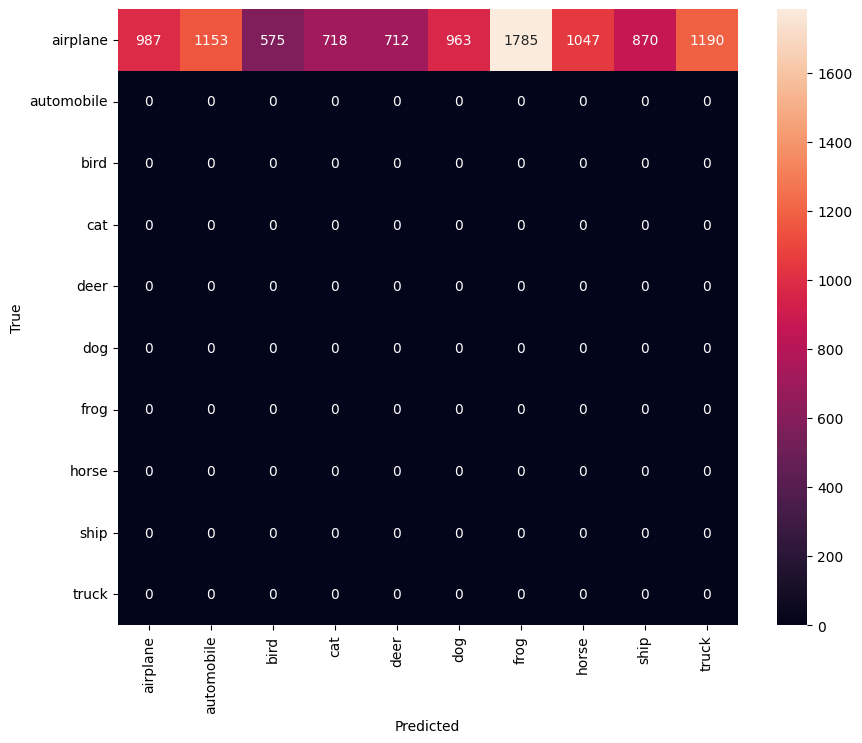

In [ ]:
# Compile the combined model
combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train the combined model
history_combined = combined_model.fit(
    datagen.flow(train_images, to_categorical(train_labels), batch_size=32),
    epochs=100,
    validation_data=(val_images, to_categorical((val_labels))),
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the combined model
test_loss, test_acc = combined_model.evaluate(test_images, to_categorical(test_labels), verbose=2)
print(f'Combined Model Test accuracy: {test_acc:.2f}')

# Predictions
test_predictions = combined_model.predict(test_images).argmax(axis=1)
test_labels_flat = test_labels.argmax(axis=1)

# Compute metrics
accuracy = accuracy_score(test_labels_flat, test_predictions)
precision = precision_score(test_labels_flat, test_predictions, average='macro')
recall = recall_score(test_labels_flat, test_predictions, average='macro')
f1 = f1_score(test_labels_flat, test_predictions, average='macro')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Classification report
print('Classification Report:')
print(classification_report(test_labels_flat, test_predictions, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(test_labels_flat, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

CNN is performing better, then I will fine tunning with lower learning rate

In [ ]:
# Create the final CNN model
final_model = create_cnn_model()
# Compile the model with a lower learning rate for fine-tuning
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
# Train the model
history_finetune = final_model.fit(
    datagen.flow(train_images, to_categorical(train_labels), batch_size=32),
    epochs=100,
    validation_data=(val_images, to_categorical(val_labels)),
    callbacks=[early_stopping, lr_scheduler]
)
# Evaluate the fine-tuned model on the test set
test_loss, test_acc = final_model.evaluate(test_images, to_categorical(test_labels), verbose=2)
print(f'Fine-tuned Model Test accuracy: {test_acc:.2f}')

Epoch 1/100
1250/1250 [==============================] - 43s 33ms/step - loss: 1.9878 - accuracy: 0.2920 - val_loss: 1.5381 - val_accuracy: 0.4483 - lr: 1.0000e-04
Epoch 2/100
1250/1250 [==============================] - 43s 34ms/step - loss: 1.7250 - accuracy: 0.3794 - val_loss: 1.4453 - val_accuracy: 0.4892 - lr: 1.0000e-04
Epoch 3/100
1250/1250 [==============================] - 41s 33ms/step - loss: 1.6295 - accuracy: 0.4147 - val_loss: 1.3206 - val_accuracy: 0.5244 - lr: 1.0000e-04
Epoch 4/100
1250/1250 [==============================] - 41s 32ms/step - loss: 1.5590 - accuracy: 0.4430 - val_loss: 1.5222 - val_accuracy: 0.4809 - lr: 1.0000e-04
Epoch 5/100
1250/1250 [==============================] - 41s 33ms/step - loss: 1.5133 - accuracy: 0.4626 - val_loss: 1.2167 - val_accuracy: 0.5695 - lr: 1.0000e-04
Epoch 6/100
1250/1250 [==============================] - 41s 33ms/step - loss: 1.4533 - accuracy: 0.4837 - val_loss: 1.1670 - val_accuracy: 0.5721 - lr: 1.0000e-04
Epoch 7/100
1250

In [6]:
model_save_path = '/content/drive/My Drive/final_cnn_model'
model_cn.save(model_save_path)